# Đánh giá mô hình
1. Vẽ biểu đồ d_loss và g_loss (trên từng epoch, với từng loại loss)
2. Đánh giá các điểm benchmark SSIM, PSNR trên các bộ dataset Set5, Set14 

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from imutils.paths import list_images
from config import config
import imutils
import cv2
import tensorlayer as tl
import os
from model import get_G, get_D

In [2]:
###====================== HYPER-PARAMETERS ===========================###
## Adam
batch_size = config.TRAIN.batch_size  # use 8 if your GPU memory is small, and change [4, 4] in tl.vis.save_images to [2, 4]
lr_init = config.TRAIN.lr_init
beta1 = config.TRAIN.beta1

## initialize G - khoi dong G
n_epoch_init = config.TRAIN.n_epoch_init
number_of_images = config.TRAIN.number_of_images
input_G_shape = config.TRAIN.input_G_shape
input_D_shape = config.TRAIN.input_D_shape
verbose = config.TRAIN.verbose
n_epochs_save_model = config.TRAIN.n_epochs_save_model
g_trained_dir = config.TRAIN.g_trained_dir
d_trained_dir = config.TRAIN.d_trained_dir
g_warmed_up_dir = config.TRAIN.g_warmed_up_dir
g_evaluate_dir = config.TRAIN.g_evaluate_dir
g_losses_txt = config.TRAIN.g_losses_txt
d_losses_txt = config.TRAIN.d_losses_txt

adv_coef = config.TRAIN.adv_coef
vgg_coef = config.TRAIN.vgg_coef
loss_type = config.TRAIN.loss_type

## adversarial learning (SRGAN)
n_epoch = config.TRAIN.n_epoch
lr_decay = config.TRAIN.lr_decay
decay_every = config.TRAIN.decay_every
shuffle_buffer_size = config.TRAIN.shuffle_buffer_size

# ni = int(np.sqrt(batch_size))

# create folders to save result images and trained models
save_dir = config.SAVE_DIR
tl.files.exists_or_mkdir(save_dir)
checkpoint_dir = config.CHECKPOINT_DIR
tl.files.exists_or_mkdir(checkpoint_dir)

[TL] [!] samples exists ...
[TL] [!] models exists ...


True

## 2. Vẽ biểu đồ d_loss và g_loss

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_losses(losses_path,label,title,figure=1,color='b'):
    def losses_to_epoch_losses(lines):
        loss_epoch = []
        loss = []
        i = 0
        losses=np.asarray(lines,dtype=np.float)
        for item in losses:
            i+=1
            loss.append(item)
            if i==100:
                i=0
                loss_epoch.append(np.mean(loss))
                loss=[]
        loss_epoch=np.array(loss_epoch)
        return loss_epoch
    with open(losses_path) as f:
        losses = [line.rstrip() for line in f]
        losses = losses[:6000]
#         print(len(losses))
        losses = losses_to_epoch_losses(losses)
        
    epoch = np.asarray(list(range(1,losses.shape[0]+1)))
    
    plt.figure(figure)
    plt.plot(epoch,losses,c=color,label=label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()

In [47]:
losses_list = list(imutils.paths.list_files('results',validExts='txt'))

In [48]:
losses_list

['results\\d_losses_maevgg_60.txt',
 'results\\d_losses_mae_60.txt',
 'results\\d_losses_msevgg_60.txt',
 'results\\d_losses_mse_60.txt',
 'results\\d_losses_vgg_60.txt',
 'results\\g_losses_maevgg_60.txt',
 'results\\g_losses_mae_60.txt',
 'results\\g_losses_msevgg_60.txt',
 'results\\g_losses_mse_60.txt',
 'results\\g_losses_vgg_60.txt']

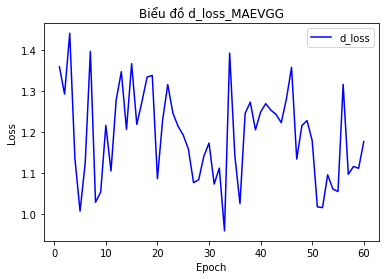

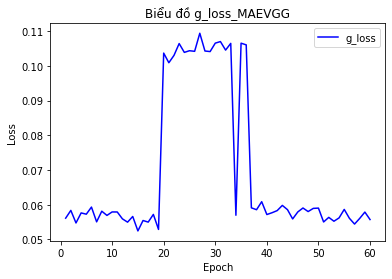

In [83]:
plot_losses(losses_list[0],label='d_loss',title='Biểu đồ d_loss_MAEVGG',figure=1)
plot_losses(losses_list[5],label='g_loss',title='Biểu đồ g_loss_MAEVGG',figure=2)

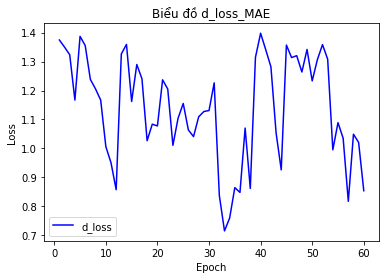

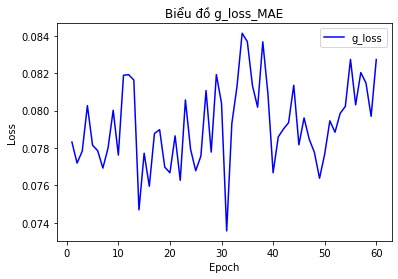

In [84]:
plot_losses(losses_list[1],label='d_loss',title='Biểu đồ d_loss_MAE',figure=1)
plot_losses(losses_list[6],label='g_loss',title='Biểu đồ g_loss_MAE',figure=2)

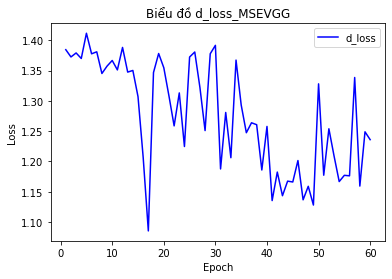

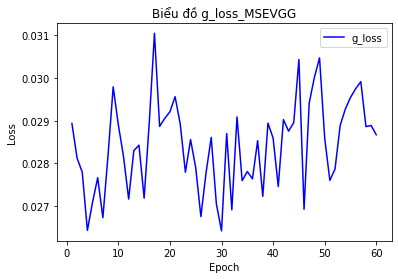

In [85]:
plot_losses(losses_list[2],label='d_loss',title='Biểu đồ d_loss_MSEVGG',figure=1)
plot_losses(losses_list[7],label='g_loss',title='Biểu đồ g_loss_MSEVGG',figure=2)

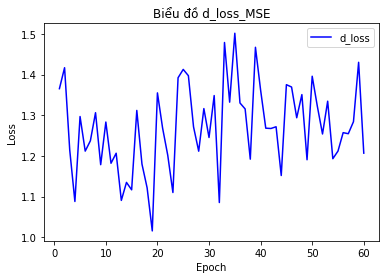

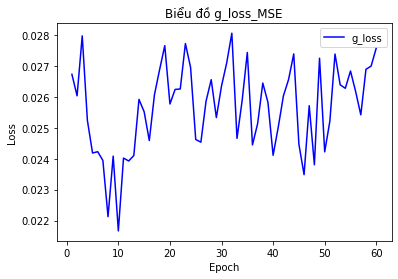

In [86]:
plot_losses(losses_list[3],label='d_loss',title='Biểu đồ d_loss_MSE',figure=1)
plot_losses(losses_list[8],label='g_loss',title='Biểu đồ g_loss_MSE',figure=2)

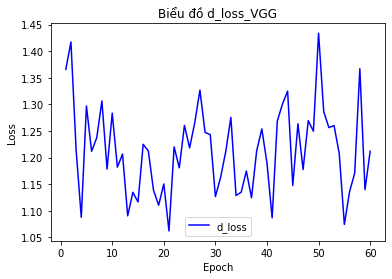

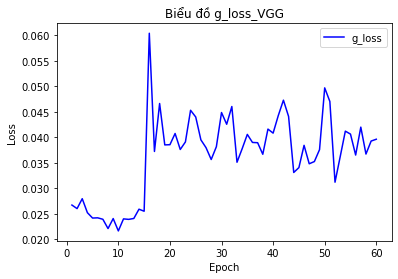

In [87]:
plot_losses(losses_list[4],label='d_loss',title='Biểu đồ d_loss_VGG',figure=1)
plot_losses(losses_list[9],label='g_loss',title='Biểu đồ g_loss_VGG',figure=2)

## 2. Đánh giá các điểm benchmark trên các tập Set5, Set14

In [4]:
def load_dataset(path):
    img_list = list(list_images(path))
    imgs = tl.vis.read_images(img_list,printable=False,n_threads=32)
    return imgs

In [5]:
def compute_score(path_ori, path_sr):
    '''
    Compute PSNR and SSIM score between original images and super resolution images
        path_ori: path to original images directory
        path_sr: path to super resolution images directory
        (images' name in path_ori and path_sr must be the same)
    '''
    ori_imgs = load_dataset(path_ori)
    sr_imgs = load_dataset(path_sr)
    PSNR_scores = []
    SSIM_scores = []
    for ori_img,sr_img in zip(ori_imgs,sr_imgs):
#         print(ori_img.shape) # height width
#         print(sr_img.shape)
        height, width = ori_img.shape[:2]
        if height%4 != 0:
            height = height-height%4
        if width%4 != 0:
            width = width-width%4
        ori_img=ori_img[:height,:width]
        PSNR_scores.append(PSNR(ori_img,sr_img))
        SSIM_scores.append(SSIM(ori_img,sr_img, multichannel=True))
    mean_PSNR_score = np.mean(np.array(PSNR_scores))
    mean_SSIM_score = np.mean(np.array(SSIM_scores))
    return mean_PSNR_score, mean_SSIM_score

In [6]:
def gen_sr(lr_path,sr_path,model_weight_path):
    '''
    Generate super resolution images from low resolution images
        lr_path: path to low resolution images directory
        sr_path: path to super resolution images directory
        model_path: path to model
    '''
    tl.files.exists_or_mkdir(sr_path,verbose=False)
    lr_img_list = list(list_images(lr_path))
    lr_imgs = tl.vis.read_images(lr_img_list, n_threads=32)

    name = [os.path.split(path)[-1] for path in lr_img_list]

    ###========================== DEFINE MODEL ============================###
    temp = []
    for img in lr_imgs:
        normalized_img = img/127.5 - 1.
        temp.append(normalized_img)

    G = get_G([None, None, 3])
    G.load_weights(model_weight_path)

    for img,name in zip(temp,name):
        img = img[np.newaxis,:,:,:]
        out = G(img).numpy()
        tl.vis.save_image(out[0], os.path.join(sr_path, name))

In [7]:
generators_list = list(imutils.paths.list_files('results',validExts='h5'))
generators_list

['results\\g_maevgg_60.h5',
 'results\\g_mae_60.h5',
 'results\\g_msevgg_60.h5',
 'results\\g_mse_60.h5',
 'results\\g_vgg_60.h5']

In [ ]:
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_maevgg',model_weight_path=generators_list[0])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_mae',model_weight_path=generators_list[1])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_msevgg',model_weight_path=generators_list[2])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_mse',model_weight_path=generators_list[3])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_vgg',model_weight_path=generators_list[4])

# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_maevgg',model_weight_path=generators_list[0])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_mae',model_weight_path=generators_list[1])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_msevgg',model_weight_path=generators_list[2])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_mse',model_weight_path=generators_list[3])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_vgg',model_weight_path=generators_list[4])

In [14]:
# Calculate PSNR scores
PSNR_score_Set5_bicu, SSIM_score_Set5_bicu = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_bicubic')
PSNR_score_Set5_mae, SSIM_score_Set5_mae = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_mae')
PSNR_score_Set5_maevgg, SSIM_score_Set5_maevgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_maevgg')
PSNR_score_Set5_mse, SSIM_score_Set5_mse = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_mse')
PSNR_score_Set5_msevgg, SSIM_score_Set5_msevgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_msevgg')
PSNR_score_Set5_vgg, SSIM_score_Set5_vgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_vgg')

In [16]:
# Calculate SSIM scores
PSNR_score_Set14_bicu, SSIM_score_Set14_bicu = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_bicubic')
PSNR_score_Set14_mae, SSIM_score_Set14_mae = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_mae')
PSNR_score_Set14_maevgg, SSIM_score_Set14_maevgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_maevgg')
PSNR_score_Set14_mse, SSIM_score_Set14_mse = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_mse')
PSNR_score_Set14_msevgg, SSIM_score_Set14_msevgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_msevgg')
PSNR_score_Set14_vgg, SSIM_score_Set14_vgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_vgg')

In [22]:
print('PSNR_score bicubic on Set5: ',PSNR_score_Set5_bicu)
print('PSNR_score bicubic on Set14: ',PSNR_score_Set14_bicu)
print('SSIM_score bicubic on Set5: ',SSIM_score_Set5_bicu)
print('SSIM_score bicubic on Set14: ',SSIM_score_Set14_bicu)

PSNR_score bicubic on Set5:  25.235032054419023
PSNR_score bicubic on Set14:  23.07668644165525
SSIM_score bicubic on Set5:  0.7523441410791492
SSIM_score bicubic on Set14:  0.6623793918240392


In [23]:
print('PSNR_score MAE on Set5: ',PSNR_score_Set5_mae)
print('PSNR_score MAE on Set14: ',PSNR_score_Set14_mae)
print('SSIM_score MAE on Set5: ',SSIM_score_Set5_mae)
print('SSIM_score MAE on Set14: ',SSIM_score_Set14_mae)

PSNR_score MAE on Set5:  26.27470577023101
PSNR_score MAE on Set14:  23.52473266914299
SSIM_score MAE on Set5:  0.7678944973544419
SSIM_score MAE on Set14:  0.666770461978822


In [24]:
print('PSNR_score MAEVGG on Set5: ',PSNR_score_Set5_maevgg)
print('PSNR_score MAEVGG on Set14: ',PSNR_score_Set14_maevgg)
print('SSIM_score MAEVGG on Set5: ',SSIM_score_Set5_maevgg)
print('SSIM_score MAEVGG on Set14: ',SSIM_score_Set14_maevgg)

PSNR_score MAEVGG on Set5:  26.293183320059228
PSNR_score MAEVGG on Set14:  23.610068547269204
SSIM_score MAEVGG on Set5:  0.7682070267655291
SSIM_score MAEVGG on Set14:  0.6689556047860895


In [25]:
print('PSNR_score MSE on Set5: ',PSNR_score_Set5_mse)
print('PSNR_score MSE on Set14: ',PSNR_score_Set14_mse)
print('SSIM_score MSE on Set5: ',SSIM_score_Set5_mse)
print('SSIM_score MSE on Set14: ',SSIM_score_Set14_mse)

PSNR_score MSE on Set5:  24.043752889789104
PSNR_score MSE on Set14:  22.57600340472553
SSIM_score MSE on Set5:  0.6370645922394571
SSIM_score MSE on Set14:  0.5677713019867374


In [26]:
print('PSNR_score MSEVGG on Set5: ',PSNR_score_Set5_msevgg)
print('PSNR_score MSEVGG on Set14: ',PSNR_score_Set14_msevgg)
print('SSIM_score MSEVGG on Set5: ',SSIM_score_Set5_msevgg)
print('SSIM_score MSEVGG on Set14: ',SSIM_score_Set14_msevgg)

PSNR_score MSEVGG on Set5:  26.096715185060198
PSNR_score MSEVGG on Set14:  23.4622318000562
SSIM_score MSEVGG on Set5:  0.7547764712159497
SSIM_score MSEVGG on Set14:  0.6618903328025855


In [27]:
print('PSNR_score VGG on Set5: ',PSNR_score_Set5_vgg)
print('PSNR_score VGG on Set14: ',PSNR_score_Set14_vgg)
print('SSIM_score VGG on Set5: ',SSIM_score_Set5_vgg)
print('SSIM_score VGG on Set14: ',SSIM_score_Set14_vgg)

PSNR_score VGG on Set5:  20.1018894979267
PSNR_score VGG on Set14:  19.228958107434586
SSIM_score VGG on Set5:  0.5849774336485116
SSIM_score VGG on Set14:  0.5055497594059203


In [ ]:
if __name__ == '__main__':
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("-hr", "--high-reso", type=str, default='archive/Set5', help="path to high resolution images directory")
    ap.add_argument("-sr", "--super-reso", type=str, default='archive/Set5_sr', help="path to super resolution images directory")

    args = vars(ap.parse_args())

    PSNR_score, SSIM_score = compute_score(args['high_reso'], args['super_reso'])
    print('PSNR_score = ',PSNR_score)
    print('SSIM_score = ',SSIM_score)    

In [128]:
# path_ori = 'archive/Set14'
# path_lr = 'archive/Set14_lr'
# path_bicubic = 'archive/Set14_bicubic'
# img_list = list(list_images(path_ori))
# for path in img_list:
#     img = cv2.imread(path)
#     height, width = img.shape[:2]
#     if height%4 != 0:
#         height = height-height%4
#     if width%4 != 0:
#         width = width-width%4
#     img=img[:height,:width]
#     width = img.shape[1]
#     name = os.path.split(path)[-1]
    
#     img_lr = imutils.resize(img,width=width//4)
#     img_bicubic = imutils.resize(img_lr,width=width)

#     new_path_lr = path_lr + '/' + name
#     new_path_bicubic = path_bicubic + '/' + name
#     cv2.imwrite(new_path_lr, img_lr)
#     cv2.imwrite(new_path_bicubic, img_bicubic)    